In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

file_path = '15topics_en.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [3]:
from sklearn.preprocessing import LabelEncoder
topics = df['topic']
#LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(topics)
train_labels.shape,np.unique(train_labels)

((2611,), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]))

In [4]:
df_X=pd.DataFrame()
df=df.fillna(' ')
df_X['X_text']=df['content']+' '+df['author']+''+df['hashtag_related 1']+''+df['hashtag_related 2']+''+df['hashtag_related 3']+''+df['hashtag_related 4']+''+df['hashtag_related 5']
df_X['Y']=train_labels
df_X.head()

,X_text,Y
0,mike levin from ca49 is a clean energy adv...,10
1,rewiring america will have an educational ...,10
2,vote to re elect president joe biden he won ...,10
3,christianity comes with privileges denied thos...,10
4,life comes at you fast when you re a populist...,10


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_X['X_text'], df_X['Y'], test_size=0.2, random_state=42)

In [6]:


# 数据准备（这里假设你有一个包含文本和标签的数据集）
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {'text': self.texts[idx], 'label': self.labels[idx]}

# 实例化数据集和数据加载器
train_texts = X_train.tolist()
train_labels = y_train.tolist()

train_dataset = CustomDataset(train_texts, train_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# 初始化 BERT 模型和令牌化器
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=15)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

# 训练模型
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True, max_length=400)
        labels = torch.tensor(batch['label']).to(device)

        inputs = {key: val.to(device) for key, val in inputs.items()}

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")

# 保存训练好的模型
model.save_pretrained('save/model_gpu')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-6-be4041b0d3ef>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Epoch 1/3, Loss: 1.7805523011419508
Epoch 2/3, Loss: 0.5082935833611251
Epoch 3/3, Loss: 0.21359597653921308


In [7]:
model.eval()
from sklearn.metrics import accuracy_score, f1_score


total_loss, total_acc = 0, 0
predicted_labels, true_labels = [], []

for batch in train_loader:
    inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True, max_length=400)
    labels = torch.tensor(batch['label']).to(device)

    inputs = {key: val.to(device) for key, val in inputs.items()}

    optimizer.zero_grad()
    outputs = model(**inputs)
    loss = criterion(outputs.logits, labels)
    total_loss += loss.item()

    # 将模型输出转换为类别标签
    _, predicted_label = torch.max(outputs.logits, 1)
    predicted_labels.extend(predicted_label.cpu().numpy())
    true_labels.extend(batch['label'])

# 计算准确率
acc = accuracy_score(true_labels, predicted_labels)
average_loss = total_loss / len(train_loader)
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Loss: {average_loss} Accuracy: {acc} f1_score: {f1}")


<ipython-input-7-c3e54806aeed>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Loss: 0.12184349435356613 Accuracy: 0.9818007662835249 f1_score: 0.9817716190889579


In [9]:
from sklearn.metrics import classification_report,  confusion_matrix

# 计算准确率
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# 计算分类报告（包括F1 Score等）
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

Accuracy: 0.9818007662835249
Confusion Matrix:
[[129   0   0   0   1   0   0   0   1   0   0   0   0   0   0]
 [  0 153   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  1   0 147   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 147   0   0   0   1   0   0   3   0   0   0   0]
 [  0   0   1   0 130   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0  92   2   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 157   0   1   0   1   1   0   0   0]
 [  0   0   0   0   0   0   0 147   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   6   0 134   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0 109   1   0   0   1   1]
 [  0   0   0   0   0   0   0   0   0   0 150   0   0   0   0]
 [  0   0   0   3   0   0   1   0   0   0   0 140   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0 132   0   0]
 [  1   0   0   0   2   0   0   0   0   0   0   2   0 129   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0 154]]
Classif

In [17]:
decoded_labels=label_encoder.inverse_transform(range(15))

In [18]:
decoded_labels

array(['Art and Culture', 'Education', 'Entertainment', 'Environment',
       'Fashion', 'Food', 'Health', 'Humor', 'Lifestyle', 'News',
       'Politics', 'Science', 'Sports', 'Technology', 'Travel'],
      dtype=object)

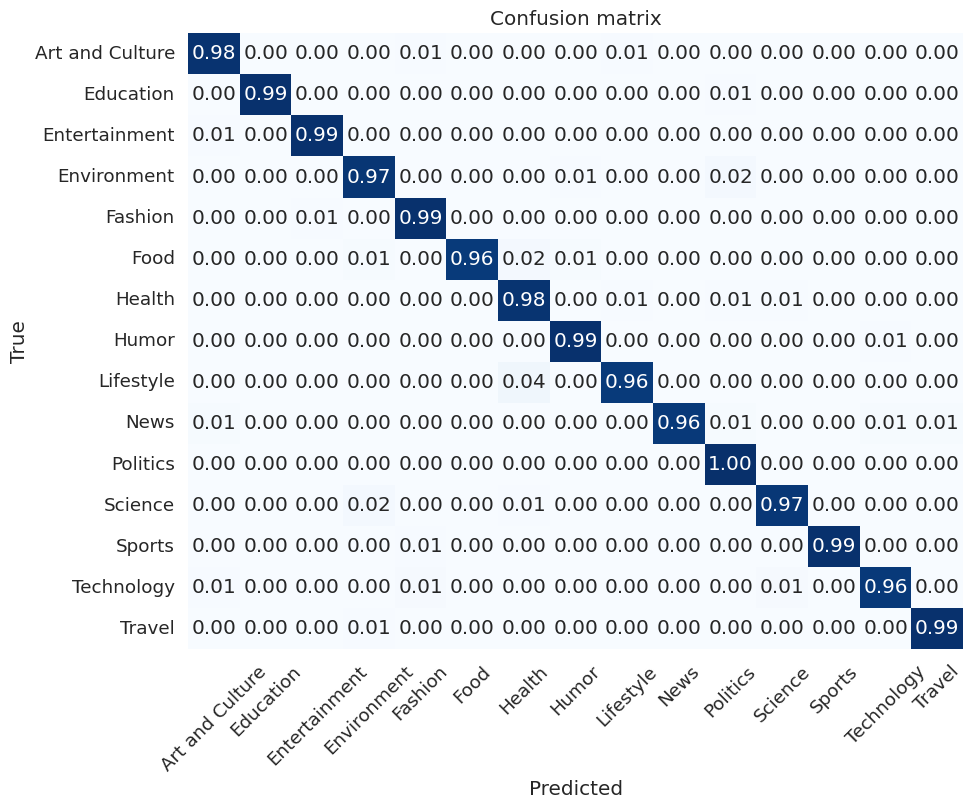

In [24]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# 将混淆矩阵进行归一化
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True,fmt=".2f", cmap="Blues", cbar=False, xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.xticks(rotation=45)
plt.savefig("Bret CM")
plt.show()

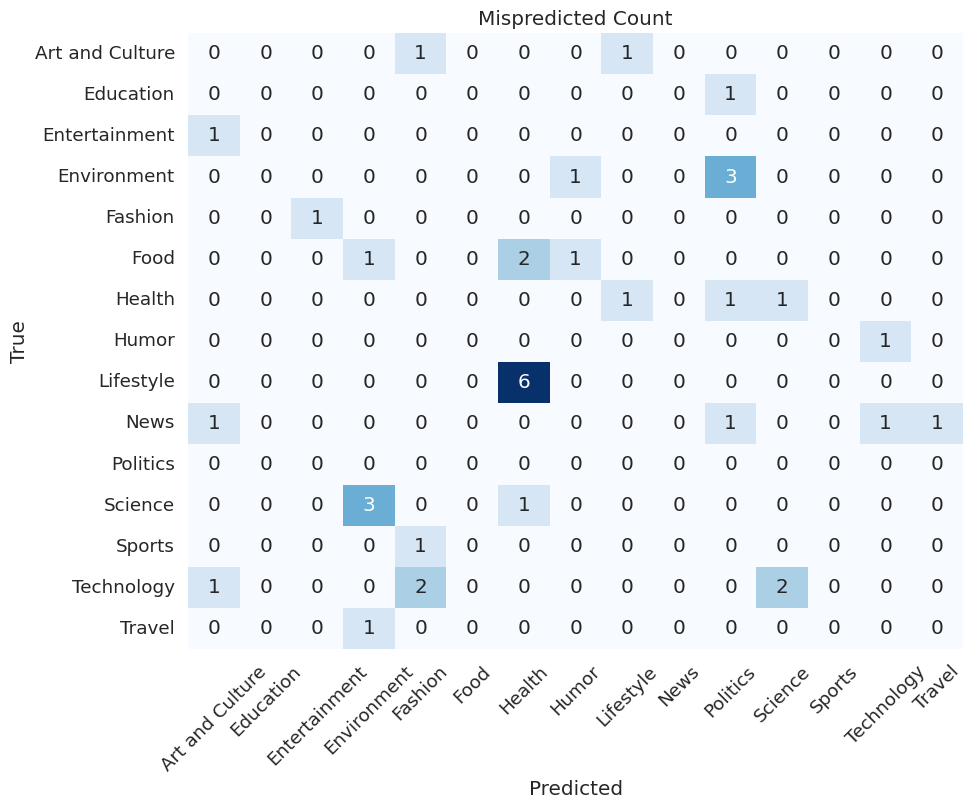

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# 示例数据（确保替换为你的实际数据）
conf_matrix = confusion_matrix(true_labels, predicted_labels)
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count')
plt.xticks(rotation=45)
plt.savefig("Bret Mispredicted")
plt.show()


In [25]:
model.eval()

test_texts = X_test.tolist()
test_labels = y_test.tolist()

test_dataset = CustomDataset(test_texts, test_labels)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

total_loss, total_acc = 0, 0
predicted_labels, true_labels = [], []

for batch in test_loader:
    inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True, max_length=400)
    labels = torch.tensor(batch['label']).to(device)

    inputs = {key: val.to(device) for key, val in inputs.items()}

    optimizer.zero_grad()
    outputs = model(**inputs)
    loss = criterion(outputs.logits, labels)
    total_loss += loss.item()

    # 将模型输出转换为类别标签
    _, predicted_label = torch.max(outputs.logits, 1)
    predicted_labels.extend(predicted_label.cpu().numpy())
    true_labels.extend(batch['label'])

# 计算准确率
acc = accuracy_score(true_labels, predicted_labels)
average_loss = total_loss / len(train_loader)
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Test set Loss: {average_loss} Accuracy: {acc} f1_score: {f1}")


<ipython-input-25-983560838e81>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch['label']).to(device)


Test set Loss: 0.06228015001620598 Accuracy: 0.9426386233269598 f1_score: 0.9419621000488692


In [26]:
# 计算准确率
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# 计算混淆矩阵
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# 计算分类报告（包括F1 Score等）
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

Accuracy: 0.9426386233269598
Confusion Matrix:
[[27  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  1  0  0  0  0  0  1  0  0]
 [ 1  0 29  0  0  0  0  1  0  0  0  1  0  0  0]
 [ 1  0  0 37  0  0  0  0  0  0  1  1  0  0  0]
 [ 0  0  1  0 29  0  0  0  2  0  0  0  0  0  0]
 [ 1  0  0  0  0 24  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  2  0  0  1  0  0  0]
 [ 0  0  1  0  0  1  0 34  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  1  0 24  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 32  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0 32  0  0  0  0]
 [ 0  1  0  1  0  0  0  1  0  0  0 44  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0 38  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  1  2  0 35  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 40]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        28
           1       0.95      0.95      0.95        40
           2       0.94      0.91      0.92   

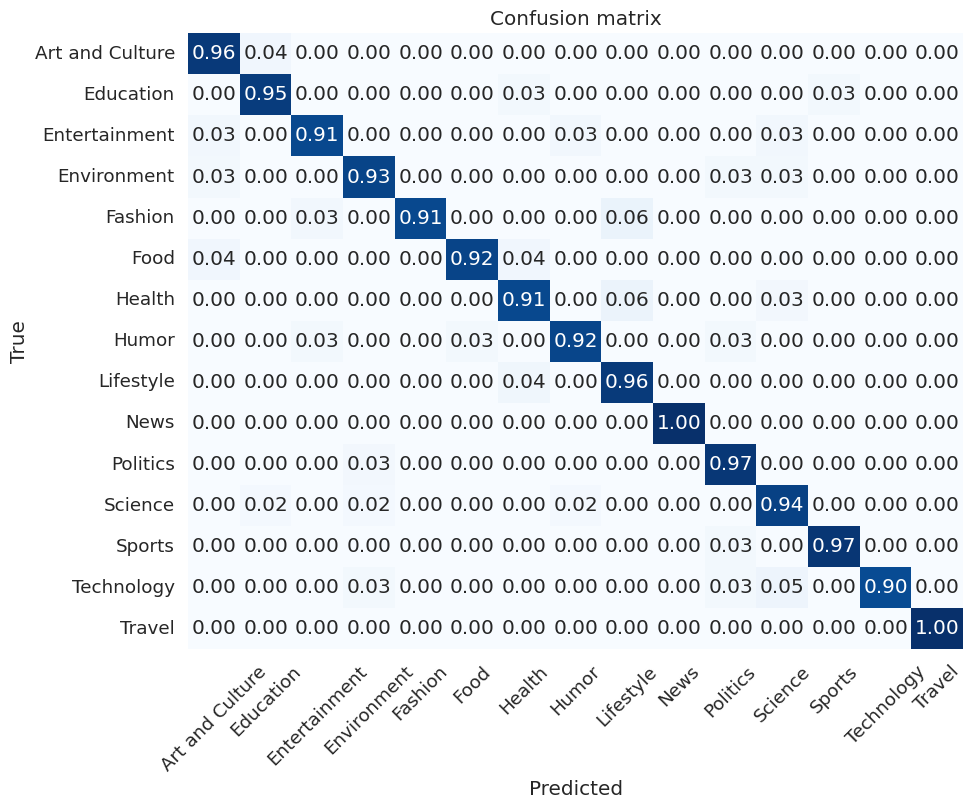

In [27]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# 将混淆矩阵进行归一化
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True,fmt=".2f", cmap="Blues", cbar=False, xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.xticks(rotation=45)
plt.savefig("Test Bret CM")
plt.show()

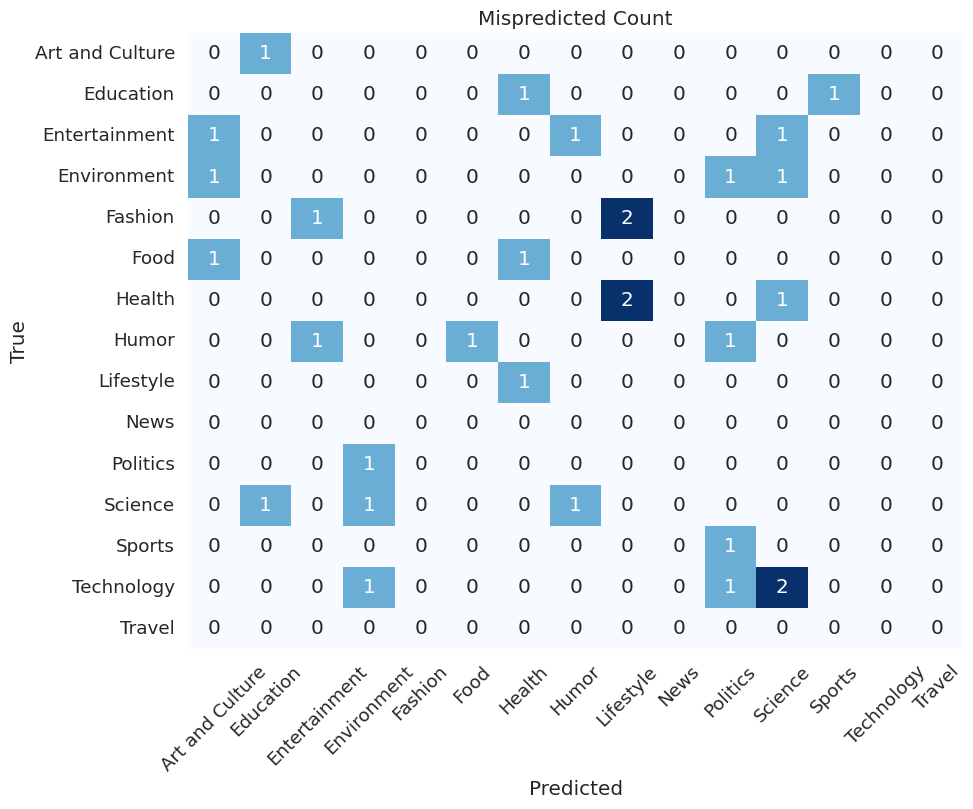

In [28]:
# 示例数据（确保替换为你的实际数据）
conf_matrix = confusion_matrix(true_labels, predicted_labels)
np.fill_diagonal(conf_matrix, 0)

# 将混淆矩阵进行归一化
#conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.astype('int')
# 使用 seaborn 绘制热力图
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", cbar=False, xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Mispredicted Count')
plt.xticks(rotation=45)
plt.savefig("Test Bret Mispredicted")
plt.show()